In [ ]:
!nvidia-smi

Wed Mar 29 16:27:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.7 MB/s eta 0:00:00


In [ ]:
!rm -r Dataset
!mkdir Dataset
!mkdir Dataset/images
!mkdir Dataset/masks

!cp /content/drive/MyDrive/small_p_data/* Dataset/images/
!cp /content/drive/MyDrive/merge_pipedata_label/* Dataset/masks/

In [ ]:
import cv2
from glob import glob
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras import backend as K
from segmentation_models.losses import bce_jaccard_loss, dice_loss, JaccardLoss, DiceLoss, BinaryCELoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

env: SM_FRAMEWORK=tf.keras


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


In [ ]:
images, masks = sorted(glob("Dataset/images/*.jpg")), sorted(glob("Dataset/masks/*.jpg"))
len(images), len(masks)

(1227, 1227)

In [ ]:
images[:5], masks[:5]

(['Dataset/images/img001.jpg',
  'Dataset/images/img002.jpg',
  'Dataset/images/img003.jpg',
  'Dataset/images/img004.jpg',
  'Dataset/images/img005.jpg'],
 ['Dataset/masks/label001.jpg',
  'Dataset/masks/label002.jpg',
  'Dataset/masks/label003.jpg',
  'Dataset/masks/label004.jpg',
  'Dataset/masks/label005.jpg'])

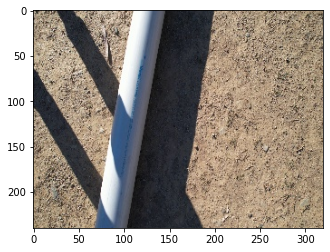

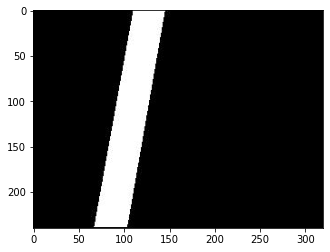

In [ ]:
plt.imshow(cv2.imread(images[750])[:,:,::-1])
plt.show()

plt.imshow(cv2.imread(masks[750],0),cmap="gray")
plt.show()

In [ ]:
m = cv2.imread(masks[750],0)
np.unique(m)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
       216, 217, 218, 219, 221, 222, 224, 225, 226, 227, 228, 230, 231,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255], dtype=uint8)

In [ ]:
m = np.where(m>199, 1, 0)
np.unique(m)

array([0, 1])

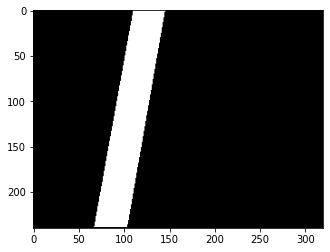

In [ ]:
plt.imshow(m, cmap="gray")
plt.show()

In [ ]:
m.shape

(240, 320)

In [ ]:
images, masks = sorted(glob("Dataset/images/*.jpg")), sorted(glob("Dataset/masks/*.jpg"))
len(images), len(masks)

(1227, 1227)

In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0it [00:00, ?it/s]

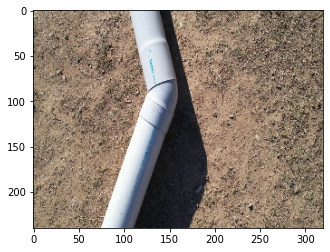

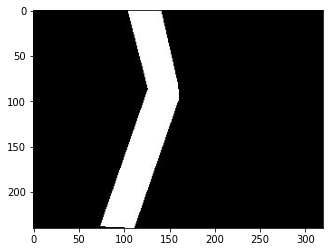

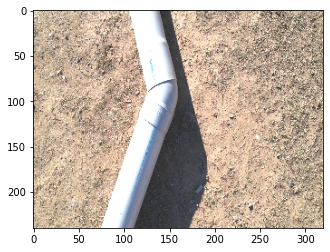

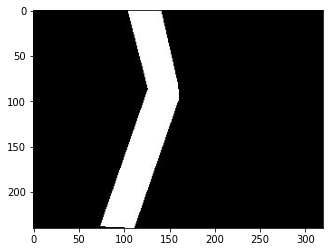

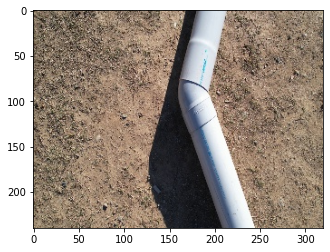

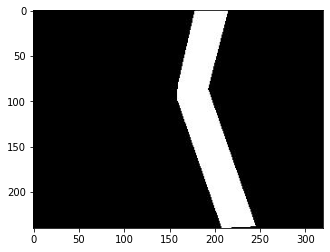

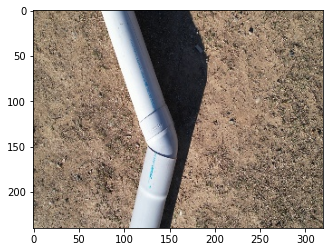

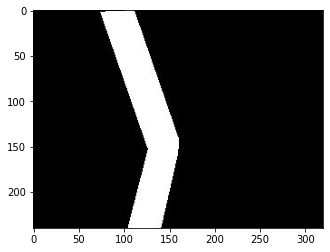

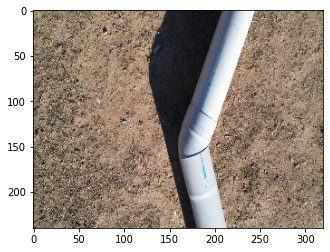

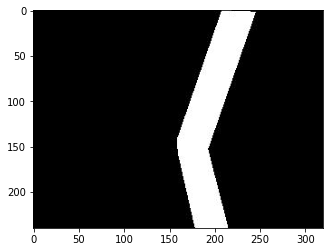

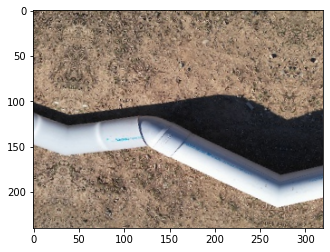

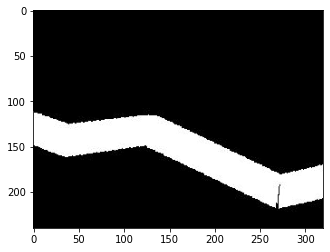

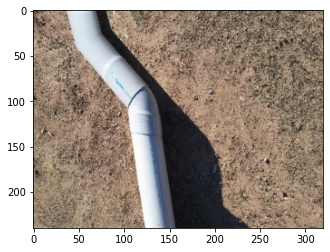

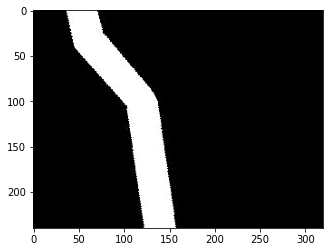

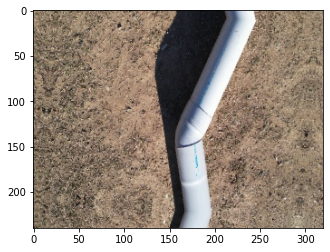

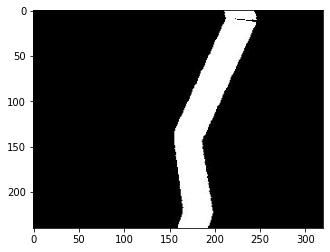

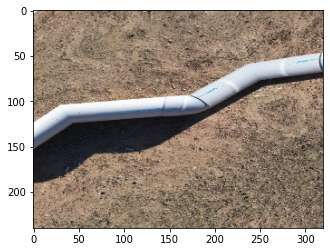

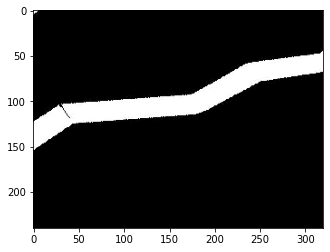

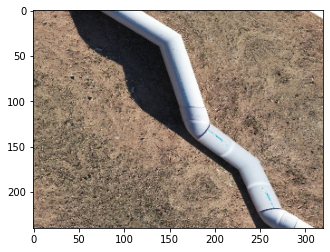

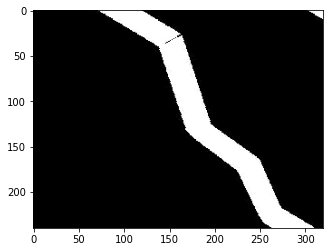

In [ ]:
import albumentations as A

l = []

for i,j in tqdm(zip(images[650:651], masks[650:651])):

  img = cv2.imread(i)[:,:,::-1]
  l.append(img)
  plt.imshow(img)
  plt.show()

  mask = cv2.imread(j,0)
  l.append(mask)
  plt.imshow(mask, cmap='gray')
  plt.show()

  transform = A.RandomBrightnessContrast(brightness_limit=(0.1, 0.3), contrast_limit=(0.1, 0.3), p=1.0, always_apply=True)
  RBC = transform(image=img, mask=mask)
  plt.imshow(RBC['image'])
  l.append(RBC['image'])
  plt.show()
  plt.imshow(RBC['mask'], cmap='gray')
  l.append(RBC['mask'])
  plt.show()

  transform = A.HorizontalFlip(p=1.0, always_apply=True)
  HFlip = transform(image=img, mask=mask)
  plt.imshow(HFlip['image'])
  l.append(HFlip['image'])
  plt.show()
  plt.imshow(HFlip['mask'], cmap='gray')
  l.append(HFlip['mask'])
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_HFlip.'+i.split('.')[1], HFlip['image'])
  # cv2.imwrite(j.split('.')[0]+'_HFlip.'+j.split('.')[1], HFlip['mask'])

  transform = A.VerticalFlip(p=1.0, always_apply=True)
  VFlip = transform(image=img, mask=mask)
  plt.imshow(VFlip['image'])
  l.append(VFlip['image'])
  plt.show()
  plt.imshow(VFlip['mask'], cmap='gray')
  plt.show()
  l.append(VFlip['mask'])
  # cv2.imwrite(i.split('.')[0]+'_VFlip.'+i.split('.')[1], VFlip['image'])
  # cv2.imwrite(j.split('.')[0]+'_VFlip.'+j.split('.')[1], VFlip['mask'])

  transform = A.VerticalFlip(p=1.0, always_apply=True)
  VHFlip = transform(image=HFlip['image'], mask=HFlip['mask'])
  l.append(VHFlip['image'])
  l.append(VHFlip['mask'])
  plt.imshow(VHFlip['image'])
  plt.show()
  plt.imshow(VHFlip['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_VHFlip.'+i.split('.')[1], VHFlip['image'])
  # cv2.imwrite(j.split('.')[0]+'_VHFlip.'+j.split('.')[1], VHFlip['mask'])

  transform = A.Rotate(p=1.0, always_apply=True)
  R = transform(image=img, mask=mask)
  l.append(R['image'])
  l.append(R['mask'])
  plt.imshow(R['image'])
  plt.show()
  plt.imshow(R['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_R.'+i.split('.')[1], R['image'])
  # cv2.imwrite(j.split('.')[0]+'_R.'+j.split('.')[1], R['mask'])

  transform = A.ShiftScaleRotate(p=1.0, always_apply=True)
  SSR = transform(image=img, mask=mask)
  l.append(SSR['image'])
  l.append(SSR['mask'])
  plt.imshow(SSR['image'])
  plt.show()
  plt.imshow(SSR['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_SSR.'+i.split('.')[1], SSR['image'])
  # cv2.imwrite(j.split('.')[0]+'_SSR.'+j.split('.')[1], SSR['mask'])

  transform = A.ShiftScaleRotate(p=1.0, always_apply=True)
  VHFlipSSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  l.append(VHFlipSSR['image'])
  l.append(VHFlipSSR['mask'])
  plt.imshow(VHFlipSSR['image'])
  plt.show()
  plt.imshow(VHFlipSSR['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_VHFlipSSR.'+i.split('.')[1], VHFlipSSR['image'])
  # cv2.imwrite(j.split('.')[0]+'_VHFlipSSR.'+j.split('.')[1], VHFlipSSR['mask'])

  transform = A.SafeRotate(p=1.0, always_apply=True)
  SR = transform(image=img, mask=mask)
  l.append(SR['image'])
  l.append(SR['mask'])
  plt.imshow(SR['image'])
  plt.show()
  plt.imshow(SR['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_RSC.'+i.split('.')[1], SR['image'])
  # cv2.imwrite(j.split('.')[0]+'_RSC.'+j.split('.')[1], SR['mask'])

  transform = A.SafeRotate(p=1.0, always_apply=True)
  VHFlipSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  l.append(VHFlipSR['image'])
  l.append(VHFlipSR['mask'])
  plt.imshow(VHFlipSR['image'])
  plt.show()
  plt.imshow(VHFlipSR['mask'], cmap='gray')
  plt.show()
  # cv2.imwrite(i.split('.')[0]+'_VHFlipSR.'+i.split('.')[1], VHFlipSR['image'])
  # cv2.imwrite(j.split('.')[0]+'_VHFlipSR.'+j.split('.')[1], VHFlipSR['mask'])


In [ ]:
len(l)

20

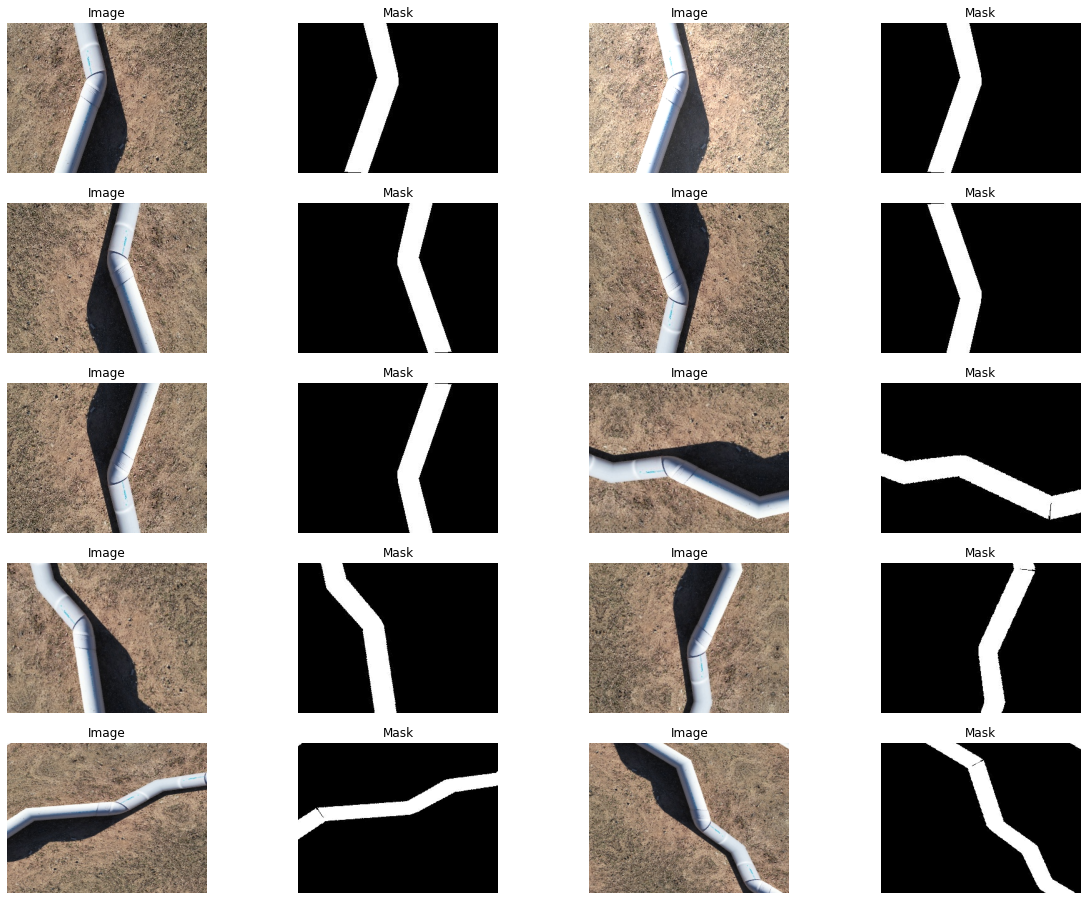

In [ ]:
plt.figure(figsize=(20, 16))
for i in range(20):
  ax = plt.subplot(5, 4, i + 1)
  if i%2 == 0:
    plt.imshow(l[i])
    plt.axis("off")
    plt.title('Image')
  else:
    plt.imshow(l[i], cmap='gray')
    plt.axis("off")
    plt.title('Mask')


In [ ]:
import albumentations as A

for i,j in tqdm(zip(images, masks)):

  img = cv2.imread(i)[:,:,::-1]
  # plt.imshow(img)
  # plt.show()

  mask = cv2.imread(j,0)
  # plt.imshow(mask)
  # plt.show()

  transform = A.RandomBrightnessContrast(brightness_limit=(0.1, 0.3), contrast_limit=(0.1, 0.3), p=1.0, always_apply=True)
  RBC = transform(image=img, mask=mask)
  # plt.imshow(RBC['image'])
  # plt.show()
  # plt.imshow(RBC['mask'], cmap='gray')
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_RBC.'+i.split('.')[1], RBC['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_RBC.'+j.split('.')[1], RBC['mask'])

  transform = A.HorizontalFlip(p=1.0)
  HFlip = transform(image=img, mask=mask)
  # plt.imshow(HFlip['image'])
  # plt.show()
  # plt.imshow(HFlip['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_HFlip.'+i.split('.')[1], HFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_HFlip.'+j.split('.')[1], HFlip['mask'])

  transform = A.VerticalFlip(p=1.0)
  VFlip = transform(image=img, mask=mask)
  # plt.imshow(VFlip['image'])
  # plt.show()
  # plt.imshow(VFlip['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_VFlip.'+i.split('.')[1], VFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VFlip.'+j.split('.')[1], VFlip['mask'])

  transform = A.VerticalFlip(p=1.0)
  VHFlip = transform(image=HFlip['image'], mask=HFlip['mask'])
  # plt.imshow(VHFlip['image'])
  # plt.show()
  # plt.imshow(VHFlip['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_VHFlip.'+i.split('.')[1], VHFlip['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlip.'+j.split('.')[1], VHFlip['mask'])

  transform = A.Rotate(p=1.0)
  R = transform(image=img, mask=mask)
  # plt.imshow(R['image'])
  # plt.show()
  # plt.imshow(R['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_R.'+i.split('.')[1], R['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_R.'+j.split('.')[1], R['mask'])

  transform = A.ShiftScaleRotate(p=1.0)
  SSR = transform(image=img, mask=mask)
  # plt.imshow(SSR['image'])
  # plt.show()
  # plt.imshow(SSR['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_SSR.'+i.split('.')[1], SSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_SSR.'+j.split('.')[1], SSR['mask'])

  transform = A.ShiftScaleRotate(p=1.0)
  VHFlipSSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  # plt.imshow(VHFlipSSR['image'])
  # plt.show()
  # plt.imshow(VHFlipSSR['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_VHFlipSSR.'+i.split('.')[1], VHFlipSSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlipSSR.'+j.split('.')[1], VHFlipSSR['mask'])

  transform = A.SafeRotate(p=1.0)
  SR = transform(image=img, mask=mask)
  # plt.imshow(SR['image'])
  # plt.show()
  # plt.imshow(SR['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_RSC.'+i.split('.')[1], SR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_RSC.'+j.split('.')[1], SR['mask'])

  transform = A.SafeRotate(p=1.0)
  VHFlipSR = transform(image=VHFlip['image'], mask=VHFlip['mask'])
  # plt.imshow(VHFlipSR['image'])
  # plt.show()
  # plt.imshow(VHFlipSR['mask'])
  # plt.show()
  cv2.imwrite(i.split('.')[0]+'_VHFlipSR.'+i.split('.')[1], VHFlipSR['image'][:,:,::-1])
  cv2.imwrite(j.split('.')[0]+'_VHFlipSR.'+j.split('.')[1], VHFlipSR['mask'])


0it [00:00, ?it/s]

In [ ]:
images, masks = sorted(glob("Dataset/images/*.jpg")), sorted(glob("Dataset/masks/*.jpg"))
len(images), len(masks)

(12270, 12270)

In [ ]:
def load_dataset(images, masks):

    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.25, random_state=360, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=360, shuffle=True)

    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(images), sorted(masks))
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

def get_data_generator(samples,batch_size):

  while True:

    for offset in range(0, len(samples), batch_size):
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []

      for batch_sample in batch_samples:

        X_image = cv2.imread(batch_sample[0])[:,:,::-1]
        X_image = X_image / 255.0
        # X_image = cv2.resize(X_image, (256, 256))
        X_image = X_image.astype(np.float32)

        Y_image = cv2.imread(batch_sample[1], 0)
        # Y_image = Y_image / 255.0
        Y_image = np.where(Y_image>199, 1.0, 0.0)
        # Y_image = cv2.resize(Y_image, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
        Y_image = tf.one_hot(Y_image, 1, dtype = np.float32)

        X_train.append(X_image)
        Y_train.append(Y_image)


      yield np.array(X_train), np.array(Y_train)


BATCH_SIZE = 64
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

7821 1381 7821 1381 3068 3068
(64, 240, 320, 3) (64, 240, 320, 1)
(64, 240, 320, 3) (64, 240, 320, 1)
(64, 240, 320, 3) (64, 240, 320, 1)


In [ ]:
np.unique(next(train_generator)[1])

array([0., 1.], dtype=float32)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, MaxPooling2D
from keras.layers import AveragePooling2D, Concatenate, Input, GlobalAveragePooling2D
from keras.models import Model


def SqueezeNet(input_shape):

    def Fire(inputs, fs, fe):

      s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
      s1 = BatchNormalization()(s1)
      e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
      e1 = BatchNormalization()(e1)
      e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
      e3 = BatchNormalization()(e3)

      output = Concatenate()([e1, e3])

      return output


    x1 = Conv2D(filters=24, kernel_size=5, strides=2, padding='same', use_bias=False, activation='relu')(input_shape)
    x1= s1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

    f2 = Fire(x1, 6, 12)
    f3 = Fire(f2, 6, 12)
    f4 = Fire(f3, 12, 24)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

    f5 = Fire(x1, 12, 24)
    f6 = Fire(f5, 24, 48)
    f7 = Fire(f6, 24, 48)
    f8 = Fire(f7, 48, 96)
    x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

    f8 = Fire(x1, 48, 96)

    return f4, f8


def ASPP(image_features):

    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=8, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=8, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=8, kernel_size=3, padding='same', dilation_rate = 2,use_bias=False)(image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=8, kernel_size=3, padding='same', dilation_rate = 4,use_bias=False)(image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    # y_18 = Conv2D(filters=8, kernel_size=3, padding='same', dilation_rate = 6,use_bias=False)(image_features)
    # y_18 = BatchNormalization(name=f'bn_5')(y_18)
    # y_18 = Activation('relu', name=f'relu_5')(y_18)

    # y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])
    y_c = Concatenate()([y_pool, y_1, y_6, y_12])

    y = Conv2D(filters=8, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y

def DeepLabV3Plus(inputs, classes=1):

    inputs = Input(inputs)

    low_level_image_features, high_level_image_features = SqueezeNet(input_shape = inputs)

    x_a = ASPP(high_level_image_features)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    x_b = Conv2D(filters=8, kernel_size=1, padding='same', use_bias=False)(low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=16, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    # x = Conv2D(filters=16, kernel_size=3, padding='same', use_bias=False)(x)
    # x = BatchNormalization(name=f'bn_9')(x)
    # x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    x = Conv2D(classes, (1, 1), name='output_layer')(x)

    if classes == 1:
      x = Activation('sigmoid')(x)
    else:
      x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model


# def main():

#     model = DeepLabV3Plus(inputs=(512,512,3), classes=1)
#     model.summary()

# if __name__== '__main__':

#     main()

In [ ]:
""" Paramaters """
input_shape = (240, 320, 3)
n_classes = 1

K.clear_session()
model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
model.save_weights('sdas.h5')

In [ ]:
""" Paramaters """
input_shape = (240, 320, 3)
epochs = 1000
lr = 1e-2
csv_path = "history.csv"
# model_name = 'PSPNet'
n_classes = 1


""" callbacks """
checkpoint_filepath = 'Seg_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    period = 3,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-5),
    CSVLogger(csv_path),
    # EarlyStopping(monitor="val_loss", patience=5)
]


""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls =  JaccardLoss()*0.5 + DiceLoss()*0.5 + BinaryCELoss()
metrics = [precision, recall, f1_score, iou_score]

K.clear_session()
model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# if model_name == 'DeepLabV3Plus':
#   model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# elif model_name == 'PSPNet':
#   model = PSPNet(inputs=input_shape, classes=n_classes)
# model.summary()

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    metrics=metrics
)

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
)

110 20
Epoch 1/1000
110/110 [==============================] - 87s 619ms/step - loss: 0.4606 - precision: 0.9565 - recall: 0.7893 - f1-score: 0.8636 - iou_score: 0.7640 - val_loss: 0.6282 - val_precision: 0.9021 - val_recall: 0.7567 - val_f1-score: 0.8230 - val_iou_score: 0.6993 - lr: 0.0100
Epoch 2/1000
110/110 [==============================] - 64s 587ms/step - loss: 0.1936 - precision: 0.9799 - recall: 0.9119 - f1-score: 0.9446 - iou_score: 0.8952 - val_loss: 0.3919 - val_precision: 0.9090 - val_recall: 0.9141 - val_f1-score: 0.9115 - val_iou_score: 0.8375 - lr: 0.0100
Epoch 3/1000
110/110 [==============================] - ETA: 0s - loss: 0.1309 - precision: 0.9835 - recall: 0.9446 - f1-score: 0.9636 - iou_score: 0.9298
Epoch 3: saving model to Seg_003.h5
110/110 [==============================] - 64s 584ms/step - loss: 0.1309 - precision: 0.9835 - recall: 0.9446 - f1-score: 0.9636 - iou_score: 0.9298 - val_loss: 0.2444 - val_precision: 0.9501 - val_recall: 0.9206 - val_f1-score: 0

KeyboardInterrupt: ignored

In [ ]:
history = pd.read_csv('history.csv')

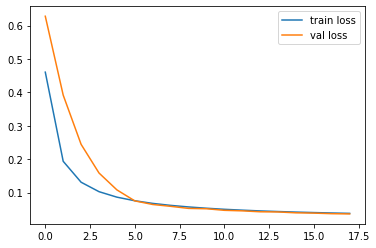

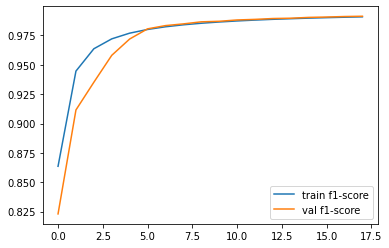

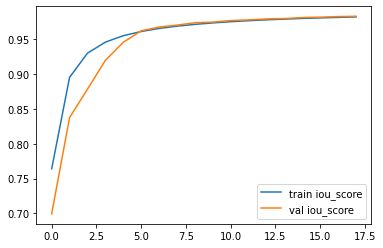

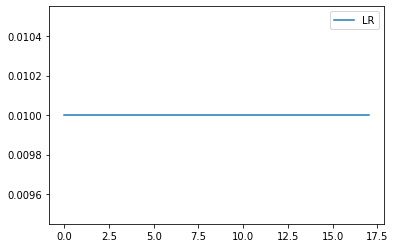

In [ ]:
# print(h.history.keys(),"\n")
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history['f1-score'], label='train f1-score')
plt.plot(history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(history['iou_score'], label='train iou_score')
plt.plot(history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(history['lr'], label='LR')
plt.legend()
plt.show()

In [ ]:
model.save('last.h5')

In [ ]:
# input_shape = (256, 256, 3)
# n_classes = 1
# lr = 0.001
# ls = dice_loss + bce_jaccard_loss
# metrics = [precision, recall, f1_score, iou_score]

# model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# model.load_weights('Seg_0030.h5')

# model.compile(
#     loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
#     metrics=metrics
# )

In [ ]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

print(test_steps)

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

44
44/44 [==============================] - 19s 429ms/step - loss: 0.0385 - precision: 0.9904 - recall: 0.9911 - f1-score: 0.9908 - iou_score: 0.9817


[0.03854968771338463,
 0.9903772473335266,
 0.9911277890205383,
 0.9907521605491638,
 0.9816740155220032]

In [ ]:
test = next(test_generator)[0]
test.shape

(64, 240, 320, 3)

In [ ]:
pred = model.predict(test)
pred.shape

2/2 [==============================] - 1s 19ms/step


(64, 240, 320, 1)

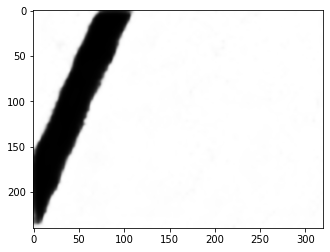

In [ ]:
plt.imshow(pred[0], cmap='gray')
plt.show()

In [ ]:
np.unique(pred[0])

array([0.0030542 , 0.00305834, 0.00306249, ..., 0.9997229 , 0.99974686,
       0.99976677], dtype=float32)

In [ ]:
# model.save_weights('PipeSeg_tiny.h5')

In [ ]:
input_shape = (240, 320, 3)
n_classes = 1
K.clear_session()
model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
model.load_weights('/content/Seg_0018.h5')
# model.summary()

In [ ]:
ls = dice_loss + bce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score]

# model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# model.load_weights('Seg_0030.h5')

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
    metrics=metrics
)

In [ ]:
model.save_weights('PipeSeg_tiny.h5')

In [ ]:
# from PipeSegTiny import DeepLabV3Plus
from keras import backend as K

K.clear_session()
m = DeepLabV3Plus((240, 320, 3), 1)
m.load_weights('PipeSeg_tiny.h5')
# m.summary()

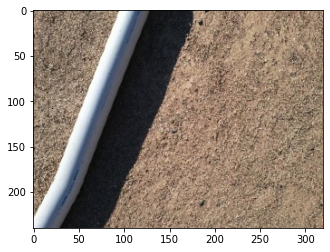

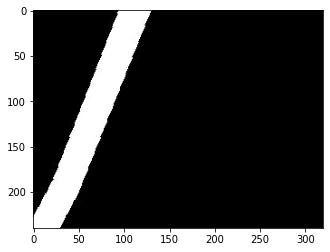

1/1 [==============================] - 1s 930ms/step
[0.0018311  0.00189065 0.00200449 ... 0.9996669  0.99966824 0.9996786 ]
[0. 1.]


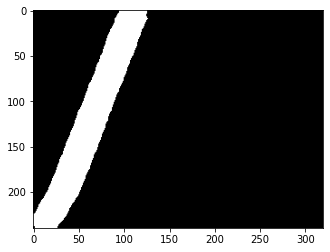

In [ ]:
img = cv2.imread(images[350])[:,:,::-1]/255.0
plt.imshow(img)
plt.show()

mask = cv2.imread(masks[350], 0)
plt.imshow(mask, cmap='gray')
plt.show()

pred = m.predict(img.reshape(1, 240, 320, 3))
print(np.unique(pred))
pred = np.where(pred>=0.5, 0.0, 1.0)
print(np.unique(pred))
# pred = cv2.bitwise_not(pred)
# pred = np.where(pred==-2, 0.0, 1.0)
plt.imshow(pred.reshape(240, 320), cmap='gray')
plt.show()

In [ ]:
np.unique(pred)

array([0., 1.])

In [ ]:
ls = dice_loss + bce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score]

# model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# model.load_weights('Seg_0030.h5')

m.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    metrics=metrics
)

In [ ]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

print(test_steps)

m.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

44
44/44 [==============================] - 19s 410ms/step - loss: 0.0498 - precision: 0.9925 - recall: 0.9897 - f1-score: 0.9911 - iou_score: 0.9824


[0.04978140816092491,
 0.9924935698509216,
 0.989743173122406,
 0.9911163449287415,
 0.9823893904685974]

In [ ]:
!pip install -q tf2onnx onnxruntime onnx2pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import onnxruntime as ort
import onnx, os, torch, tf2onnx
from onnx2pytorch import ConvertModel
import matplotlib.pyplot as plt
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(tf.__version__)
print(keras.__version__)
print(onnx.__version__)
print(torch.__version__)

2.11.0
2.11.0
1.13.1
1.13.1+cu116


In [ ]:
# model_name = 'SQNet'
# keras_model_path = f'/content/KModel_{model_name}/'
# onnx_model_path = f'/content/Onnx_{model_name}'
# tf_model_path = f'/content/TFModel_{model_name}/'
# pytorch_model_path = f'/content/PTModel_{model_name}'
image_shape = [240, 320, 3]
batch_size = 1
opset_value = 10
num_classes = 1


def Keras2Onnx(keras_model_path, onnx_model_path, image_shape, batch_size):
  # KModel = tf.keras.models.load_model(keras_model_path)
  # from PipeSegTiny import DeepLabV3Plus
  K.clear_session()
  KModel = DeepLabV3Plus(image_shape, num_classes)
  KModel.load_weights(keras_model_path)
  input_signature = [tf.TensorSpec([batch_size]+image_shape, tf.float32)]
  onnx_model, _ = tf2onnx.convert.from_keras(KModel, input_signature, opset=opset_value)
  onnx.save(onnx_model, onnx_model_path)
  print('------------------------------------------------------')
  print(f'Keras Model "{keras_model_path}" is converted to Onnx "{onnx_model_path}"!!!')
  print('------------------------------------------------------')


def Onnx2Pytorch(onnx_model_path, pytorch_model_path):
  onnx_model = onnx.load(onnx_model_path)
  pytorch_model = ConvertModel(onnx_model)
  torch.save(pytorch_model, pytorch_model_path)
  print('------------------------------------------------------')
  print(f'Onnx Model "{onnx_model_path}" is converted to Pytorch "{pytorch_model_path}"!!!')
  print('------------------------------------------------------')


In [ ]:
keras_model_path = '/content/PipeSeg_tiny.h5'
onnx_model_path = '/content/PipeSeg_tiny.onnx'
Keras2Onnx(keras_model_path, onnx_model_path, image_shape, batch_size)

------------------------------------------------------
Keras Model "/content/PipeSeg_tiny.h5" is converted to Onnx "/content/PipeSeg_tiny.onnx"!!!
------------------------------------------------------


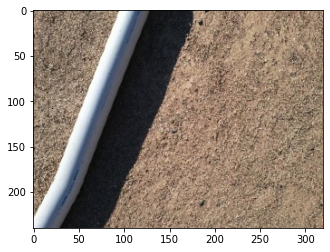

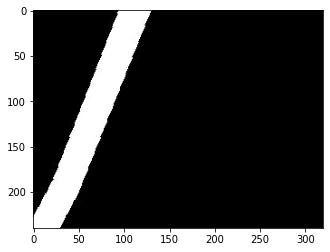

Prediction on an image from test dataset using Onnx Model:
[0.00182304 0.00196171 0.00196397 ... 0.99975425 0.9997637  0.99981105]


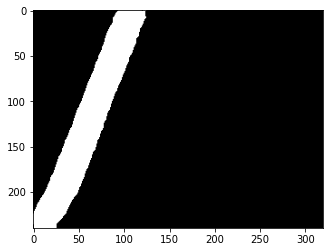

In [ ]:
img = cv2.imread(images[350])[:,:,::-1]/255.0
plt.imshow(img)
plt.show()

mask = cv2.imread(masks[350], 0)
plt.imshow(mask, cmap='gray')
plt.show()

# pred = m.predict(img.reshape(1, 240, 320, 3))
# pred = np.where(pred>=0.4, 1, 0)
# pred = cv2.bitwise_not(pred)
# pred = np.where(pred==-2, 0.0, 1.0)
# plt.imshow(pred.reshape(240, 320), cmap='gray')
# plt.show()

sess = ort.InferenceSession(onnx_model_path)
inp, out = sess.get_inputs()[0], sess.get_outputs()[0]
print("Prediction on an image from test dataset using Onnx Model:")
pred = sess.run([out.name], {inp.name: img.reshape(1, 240, 320, 3).astype(np.float32)})[0].reshape(240, 320)
print(np.unique(pred))
pred = np.where(pred>0.5, 0.0, 1.0)
# pred = cv2.bitwise_not(pred)
# pred = np.where(pred==-2, 0.0, 1.0)
plt.imshow(pred, cmap='gray')
plt.show()
# print("Prediction Probabilities: ",res)
# print("Predicted Class: ",np.argmax(res))

In [ ]:
img.dtype

dtype('float64')

In [ ]:
pred.shape

(240, 320)

In [ ]:
pred = pred.reshape(240, 320)
# pred = np.where(pred>=0.5, 1, 0)
np.unique(pred)

array([0., 1.])

In [ ]:
pytorch_model_path = '/content/PipeSeg_tiny.pth'
onnx_model_path = '/content/PipeSeg_tiny.onnx'

Onnx2Pytorch(onnx_model_path, pytorch_model_path)

------------------------------------------------------
Onnx Model "/content/PipeSeg_tiny.onnx" is converted to Pytorch "/content/PipeSeg_tiny.pth"!!!
------------------------------------------------------


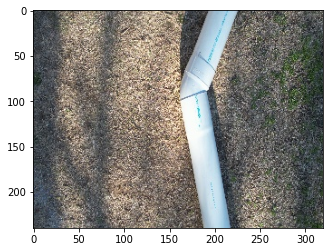

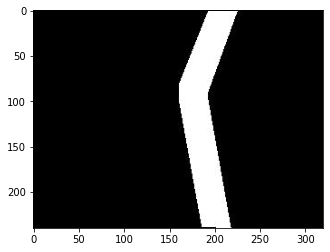

ValueError: ignored

In [ ]:
img = cv2.imread(images[1020])[:,:,::-1]/255.0
plt.imshow(img)
plt.show()
img = torch.from_numpy(img.reshape(1, 240, 320, 3).astype(np.float32))

mask = cv2.imread(masks[1020], 0)
plt.imshow(mask, cmap='gray')
plt.show()

PTmodel = torch.load(pytorch_model_path)
PTmodel.eval()
with torch.inference_mode():
  pred = PTmodel(img)
  # pred = np.where(pred>0.5, 1, 0)
  # pred = cv2.bitwise_not(pred)
  # pred = np.where(pred==-2, 0.0, 1.0)
  plt.imshow(pred.reshape(240, 320), cmap='gray')
  plt.show()

In [ ]:
s = torch.from_numpy(img)
s.shape, s.dtype

In [ ]:
s = s.to(torch.double)
s.dtype

In [ ]:
# from PipeSegTiny import DeepLabV3Plus
from keras import backend as K

K.clear_session()
m = DeepLabV3Plus((240, 320, 3), 1)
m.load_weights('PipeSeg_tiny.h5')
# m.summary()

## testing of the onnx model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import onnxruntime as ort
import onnx, os, torch, tf2onnx
from onnx2pytorch import ConvertModel
import matplotlib.pyplot as plt
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

sess = ort.InferenceSession('PipeSeg_tiny.onnx') ## Path of your onnx model file
inp, out = sess.get_inputs()[0], sess.get_outputs()[0]

0


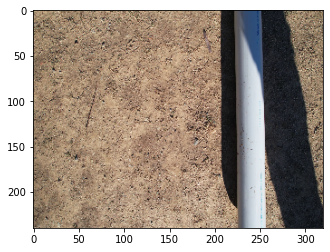

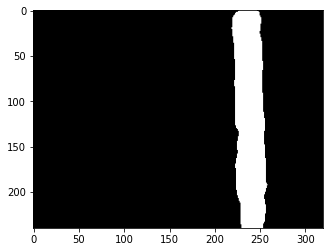

500


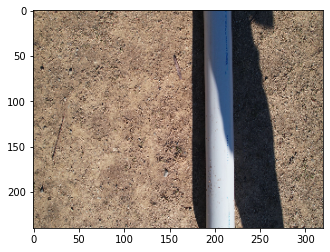

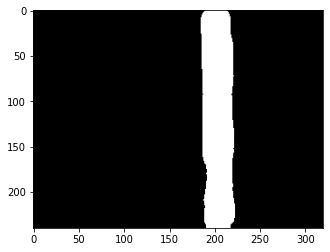

1000


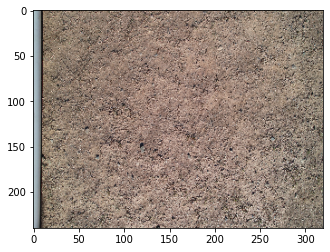

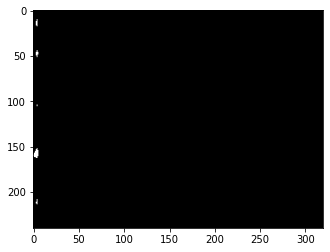

1500


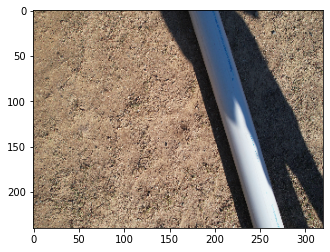

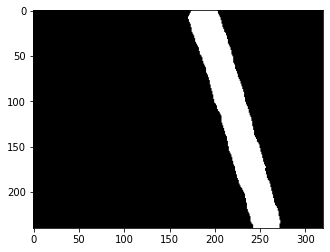

2000


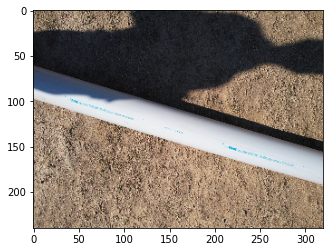

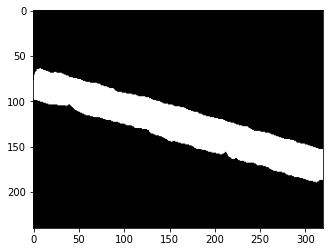

2500


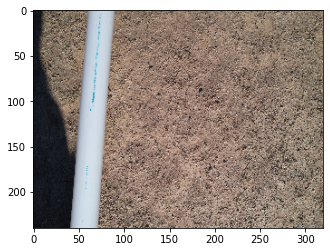

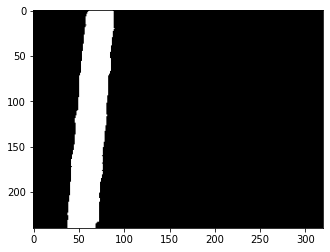

3000


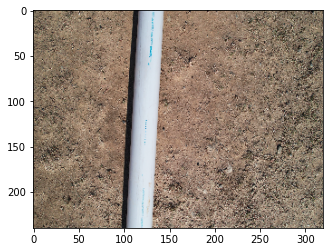

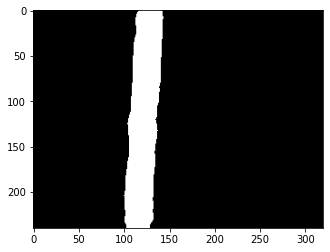

3500


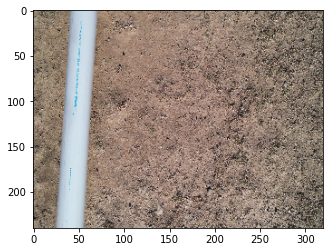

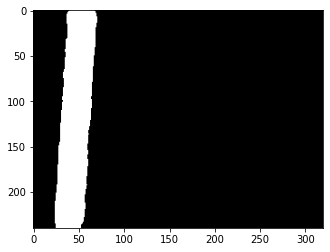

4000


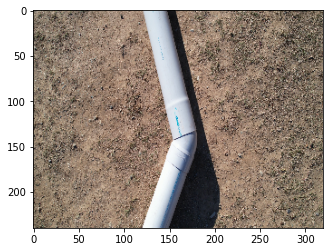

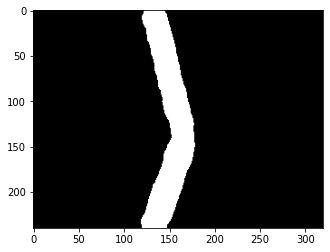

4500


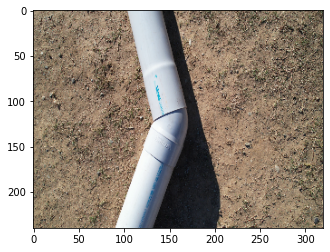

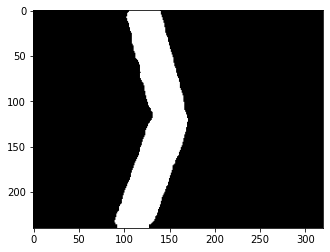

5000


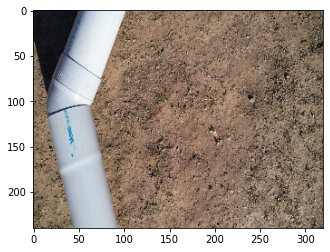

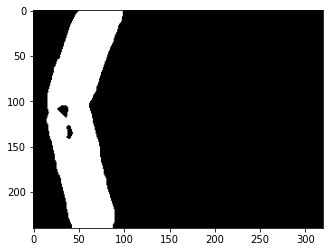

5500


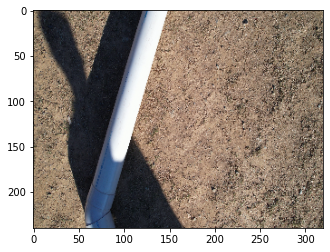

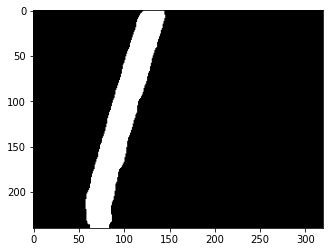

6000


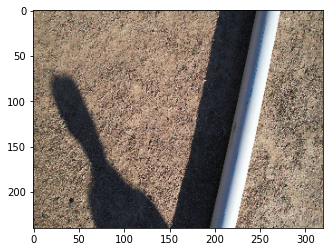

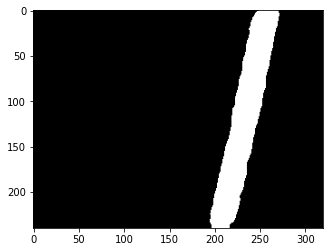

6500


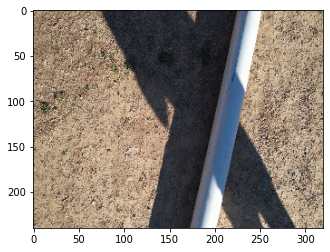

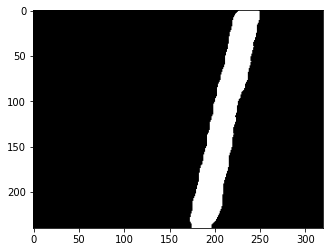

7000


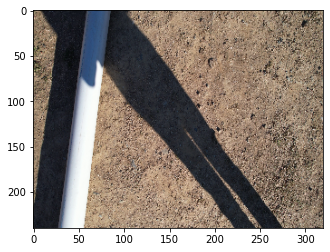

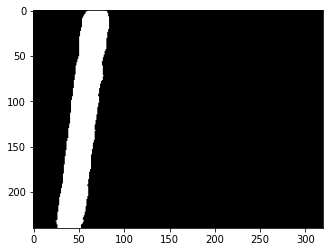

7500


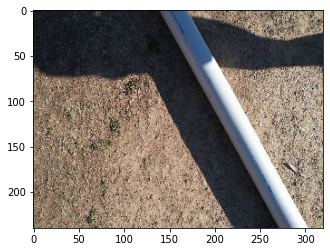

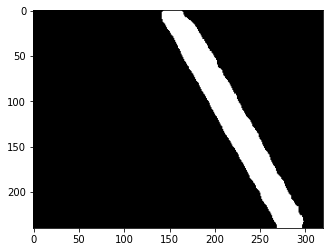

8000


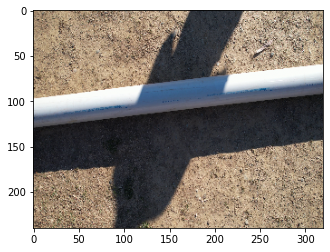

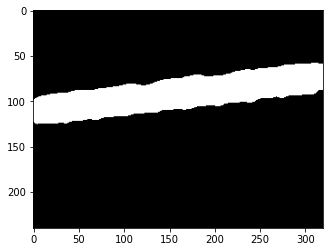

8500


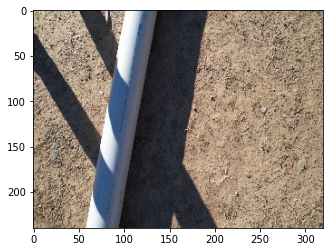

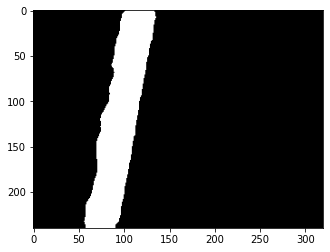

The video was successfully saved


In [ ]:
# Python program to save a
# video using OpenCV


import cv2


# Create an object to read
# from camera
video = cv2.VideoCapture('/content/drive/MyDrive/PipeSeg/DJI_0463.MP4')

# We need to check if camera
# is opened previously or not
if (video.isOpened() == False):
	print("Error reading video file")

# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))

size = (frame_width, frame_height)

# Below VideoWriter object will create
# a frame of above defined The output
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('output.avi',
						cv2.VideoWriter_fourcc(*'MJPG'),
						30, size)

c = 0
while(True):
	ret, frame = video.read()

	if ret == True:


		if c % 500 != 0:
			c+=1
			continue

		print(c)
		frame = cv2.resize(frame, (320, 240)) ## Resize your images according to your model input
		frame = frame[:,:,::-1]/255.0 ## If your traning is done on the normalized image otherwise comment this line
		plt.imshow(frame)
		plt.show()
		frame = frame.reshape(1, 240, 320, 3).astype(np.float32)

		# pred = m.predict(frame)

		pred = sess.run([out.name], {inp.name: frame})[0].reshape(240, 320)

		pred = np.where(pred>=0.5, 0, 1)*255 #.astype(np.uint8)
		pred = pred.reshape(240, 320).astype(np.uint8)
		pred = np.dstack([pred, pred, pred]) ## not necessary,  here we did because we want to stack output(binary) of model with input(RGB) image
		# print(np.unique(pred))
		# result.write(pred)

		plt.imshow(pred)
		plt.show()

		c += 1

		# Press S on keyboard to stop the process
		if cv2.waitKey(1) & 0xFF == ord('s'):
			break



	# Break the loop
	else:
		break

video.release()
result.release()

cv2.destroyAllWindows()

print("The video was successfully saved")


In [ ]:
c

8715

In [ ]:
h = int(video.get(cv2.CAP_PROP_FOURCC))
codec = chr(h&0xff) + chr((h>>8)&0xff) + chr((h>>16)&0xff) + chr((h>>24)&0xff)
codec

'\x00\x00\x00\x00'